In [27]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torchvision
from PIL import Image
import os

In [3]:
# load image
_,_, files = next(os.walk('data/ean13/'))


In [4]:
files

['100_7909336161504_ean13.png',
 '10_1989122259024_ean13.png',
 '11_3543421134192_ean13.png',
 '12_7635954480177_ean13.png',
 '13_7142942944516_ean13.png',
 '14_8868330163619_ean13.png',
 '15_8715903783777_ean13.png',
 '16_5619020065187_ean13.png',
 '17_5905730569924_ean13.png',
 '18_4074735548607_ean13.png',
 '19_9332515673914_ean13.png',
 '1_2230054015011_ean13.png',
 '20_2752596591971_ean13.png',
 '21_5668549538504_ean13.png',
 '22_4064040428701_ean13.png',
 '23_3368909806565_ean13.png',
 '24_9416298215391_ean13.png',
 '25_2131148122816_ean13.png',
 '26_5170101680816_ean13.png',
 '27_4912574176233_ean13.png',
 '28_4815970826439_ean13.png',
 '29_3903557923877_ean13.png',
 '2_9118562393131_ean13.png',
 '30_1507112298237_ean13.png',
 '31_6056453477924_ean13.png',
 '32_2354470682937_ean13.png',
 '33_1875251387076_ean13.png',
 '34_4244935436657_ean13.png',
 '35_7907570332667_ean13.png',
 '36_4988379941772_ean13.png',
 '37_3129331061119_ean13.png',
 '38_1760405570407_ean13.png',
 '39_8260

(523, 280)


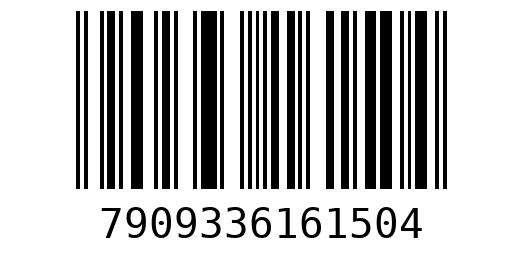

In [7]:
#load 1 image
img = Image.open('data/ean13/'+files[0])
print(img.size)
img.show()

In [ ]:
# Define the base directory for your dataset
base_dir = 'data/ean13/'
_,_, files = next(os.walk('data/ean13/'))

dataset_size = len(files)
train_data = files[:int(0.8*dataset_size)]  
test_data = files[int(0.8*dataset_size):]

# Function to ensure directory structure
def ensure_dir(path):
    if not os.path.exists(path):
        os.makedirs(path)
        print(f"Created directory: {path}")
    else:
        print(f"Directory already exists: {path}")

# Create class subdirectories in train and test directories
train_class_dir = os.path.join(base_dir, 'train/all')
test_class_dir = os.path.join(base_dir, 'test/all')
ensure_dir(train_class_dir)
ensure_dir(test_class_dir)

# Move the images to the appropriate class subdirectory in train/test folders
for file in train_data:
    source = os.path.join(base_dir, file)
    destination = os.path.join(train_class_dir, file)
    if os.path.exists(source):
        os.rename(source, destination)
        print(f"Moved {source} to {destination}")
    else:
        print(f"File {file} does not exist in the source directory.")

for file in test_data:
    source = os.path.join(base_dir, file)
    destination = os.path.join(test_class_dir, file)
    if os.path.exists(source):
        os.rename(source, destination)
        print(f"Moved {source} to {destination}")
    else:
        print(f"File {file} does not exist in the source directory.")

In [43]:
# Define a function to convert images to binary
def to_binary(tensor, threshold=0.5):
    # Convert to grayscale by averaging the channels
    grayscale = tensor.mean(dim=0, keepdim=True)
    # Apply threshold
    binary = (grayscale > threshold).float()
    return binary

# Create the transform pipeline
transform = transforms.Compose([
    transforms.Resize((256, 512)),
    transforms.ToTensor(),
    transforms.Lambda(lambda x: to_binary(x))
])
print(f"Loading train dataset from: {os.path.join(base_dir, 'train')}")
print(f"Loading test dataset from: {os.path.join(base_dir, 'test')}")
# Verify paths and load the data

train_dataset = datasets.ImageFolder(os.path.join(base_dir, 'train'), transform=transform)
test_dataset = datasets.ImageFolder(os.path.join(base_dir, 'test'), transform=transform)

# DataLoader
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=4, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=4, shuffle=True)

Loading train dataset from: data/ean13/train
Loading test dataset from: data/ean13/test


torch.Size([1, 1, 256, 512])


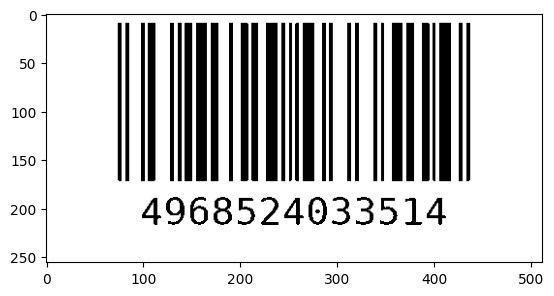

In [44]:
import matplotlib.pyplot as plt
import numpy as np

# Function to convert a tensor to a numpy array
def imshow(img):
    img = img.numpy() # Convert tensor to numpy array
    plt.imshow(np.transpose(img, (1, 2, 0))) # Convert from CxHxW to HxWxC
    plt.show()

# Get a batch of training images
dataiter = iter(train_loader)
images, labels = next(dataiter) # Use next() to get the next batch

# Show images for the first image in the batch
print(images[0].unsqueeze(0).shape)
imshow(torchvision.utils.make_grid(images[0].unsqueeze(0)))

In [49]:
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(16, 8, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(8, 16, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 1, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid()
        )
         
    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [50]:
model = Autoencoder()

In [52]:
# Move the model to GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
model.to(device)
 
# Define the loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
 
# Train the autoencoder
num_epochs = 10
for epoch in range(num_epochs):
    for data in train_loader:
        img, _ = data
        img = img.to(device)
        optimizer.zero_grad()
        output = model(img)
        loss = criterion(output, img)
        loss.backward()
        optimizer.step()
    if epoch % 5== 0:
        print('Epoch [{}/{}], Loss: {:.4f}'.format(epoch+1, num_epochs, loss.item()))
 
# Save the model
torch.save(model.state_dict(), 'conv_autoencoder.pth')

cpu
Epoch [1/10], Loss: 0.1658
Epoch [6/10], Loss: 0.0466
